# Lab 3 — clustering

In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import json
import operator
import pickle
import random
import math
import matplotlib.pyplot as plt
import numpy as np

from functools import reduce
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool

In [2]:
output_notebook()

%matplotlib inline
plt.style.use("ggplot")

Loading BokehJS ...

## Exercise 3.11

In [3]:
with open("tags_coordinates.pickle", "rb") as f:
    tags_coordinates = pickle.load(f, encoding="utf-8")

tags = [(k,v) for k,v in tags_coordinates.items()]
X = np.asarray(list(tags_coordinates.values()))

In [4]:
kmeans = [KMeans(n_clusters=i).fit(X) for i in range(2, 6)]

In [5]:
# PCA done in 3.2 ?
pca = PCA(n_components=2)
pca.fit(X)

t = pca.transform(X)

In [6]:
def get_color(x):
    if x == 0:
        return "#0000FF"
    elif x == 1:
        return "#00FF00"
    elif x == 2:
        return "#FF0000"
    elif x == 3:
        return "#FFFF00"
    else:
        return "#00FFFF"

In [7]:
# Plots the given number of clusters + 2 along the two given principal directions

def plot(i, axis1, axis2):
    if axis1 == axis2:
        raise Exception("The axes must be different")
    
    source = ColumnDataSource(
        data={
            "x": [x[1][axis1] for x in tags],
            "y": [x[1][axis2] for x in tags],
            "name": [x[0] for x in tags],
            "color": [get_color(x) for x in kmeans[i].labels_],
        })
    hover = HoverTool(
        tooltips=[
            ("Name", "@name"),
        ])
    tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

    p = figure(plot_width=960, tools=tools)
    p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
    show(p, notebook_handle=True)

The following graphs are printed on axes that separate the clusters well. Graphs with poorly separated clusters are not shown. Based on the results of exercise 3.2 the axes are labeled as follows:

0. Movie quality
1. Action vs. Feelings
2. Horror vs. Feel-good
3. Violent vs. Peaceful
4. Funny vs. Tense

In [8]:
# x -> movie quality ; y -> Funny/Tense
plot(0, 0, 4)

In [9]:
# x -> Violence/Peace ; y -> Funny/Tense
plot(1, 3, 4)

In [10]:
# x -> Action/Feelings ; y -> Funny/Tense
plot(2, 1, 4)

In [11]:
# x -> Horror/Feel-good ; y -> Violence/Peace
plot(3,2,3)

## Exercise 3.12

In [12]:
with open("most-rated.pickle", "rb") as f:
    most_rated = pickle.load(f, encoding="utf-8")
    
most_rated_ids = list(map(operator.itemgetter(0), most_rated))

In [13]:
data = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
data = data.filter(lambda x: x.get('movieId') in most_rated_ids)

movies = data.collect()

In [14]:
def jaccard(x, y):
    A = set(x.get('genres'))
    B = set(y.get('genres'))
    n = len(A.intersection(B))
    d = len(A.union(B))
    return 1 - n/d

In [15]:
def kmedioids(X, d, k):
    m = [random.choice(X) for _ in range(k)]
    c = [0 for _ in range(len(X))]
    
    delta = math.inf
    delta_prev = 0
    epsilon = len(X) / 100
    
    while delta != delta_prev:
        print("Delta:", delta)
        delta_prev = delta
        delta = 0
        for i, x in enumerate(X):
            dists = [d(x, j) for j in m]
            clus = dists.index(min(dists))
            delta += abs(clus - c[i])
            c[i] = clus
            
        for i in range(k):
            nodes = [j for j, x in enumerate(c) if x == i]            
            dists = []
            for j, x in enumerate(X):
                if c[j] == i:
                    dists.append((sum([d(x, X[y]) for y in nodes])))
                else:
                    dists.append(math.inf)
            m[i] = X[dists.index(min(dists))]
    
    # Returns tuple with mediods and cluster assignements
    return m, c

In [16]:
km = kmedioids(movies, jaccard, 2)

Delta: inf
Delta: 90
Delta: 125
Delta: 158
Delta: 70
Delta: 0


In [17]:
genres = set(reduce(lambda x, y: x + y, (map(operator.itemgetter('genres'), movies))))

649


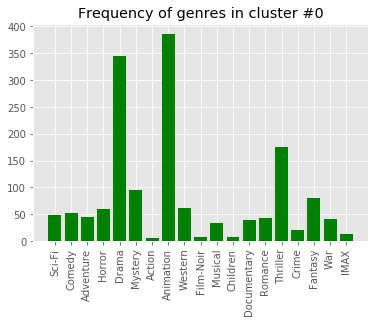

351


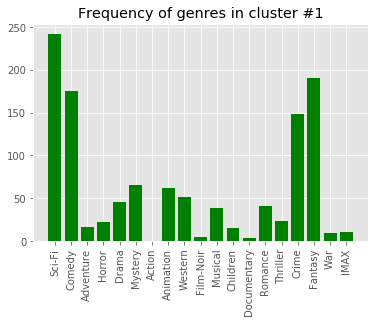

In [18]:
# For each cluster, show a plot of the frequency of genres it contains
for i in range(len(km[0])):
    freqs = {k: 0 for k in genres}
    nodes = [movies[j].get('genres') for j, x in enumerate(km[1]) if x == i]
    print(len(nodes))
    for n in nodes:
        for m in n:
            freqs[m] += 1
    plt.title("Frequency of genres in cluster #" + str(i))
    plt.bar(freqs.keys(), freqs.values(), color='g')
    # Set the labels in vertical orientation
    plt.xticks(range(len(freqs.keys())), freqs.keys(), rotation='vertical')
    plt.show()

Because we only compute two clusters we can see that each cluster is composed of several well represented genres while the less represented ones are split between the two. With more clusters we could reach a more precise separation.

With the amount of precision offered by the two clusters we can see that the most opposed genres, comedy and drama, are separated while genres that work well together like sci-fi and animation or crime and drama are separated arbitrarily when optimizing the distance.